# Solar Power Forecasting with LSTM Network

## GermanSolarFarm Dataset
The GermanSolarFarm data set contains 21 photovoltaic facilities
in Germany. Their installed nominal power ranges between
100kW and 8500kW. The PV facilities range from PV panels
installed on rooftops to fully fledged solar farms. They are
distributed throughout Germany as shown in the attached image.
For each facility historical NWP data and the produced
power in a three-hour resolution for 990 days are available.
All time series in the data set, except the measured power
output, are normalized between 0 and 1 using the minmax
normalization. The target variable, the measured power
output, is normalized using the nominal output capacity of the
corresponding PV facility. Therefore, allow the comparison of
the forecasting performance without taking the size of the PV
facilities into account. 

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data/pv_01.csv', sep=';')

In [4]:
df.head()

,time_idx,hour_of_day,hour_of_day_cos,hour_of_day_sin,month_of_year,month_of_year_cos,month_of_year_sin,season_of_year,season_of_year_cos,season_of_year_sin,...,LowerWindDirectionMath,LowerWindDirectionCos,LowerWindDirectionSin,UpperWindSpeed,UpperWindDirection,UpperWindDirectionMath,UpperWindDirectionCos,UpperWindDirectionSin,power_normed,Unnamed: 51
0,1.0,0.000000,1.000000,0.000000,0.909091,0.017332,0.258819,1.0,0.0,0.0,...,0.190752,0.681740,0.965801,0.359087,0.577455,0.172559,0.733785,0.941978,0.000000,NaN
1,2.0,0.142857,0.957824,0.399332,0.909091,0.017332,0.258819,1.0,0.0,0.0,...,0.217852,0.600192,0.989859,0.475393,0.545543,0.204424,0.641217,0.979643,0.000000,NaN
2,3.0,0.285714,0.838278,0.732544,0.909091,0.017332,0.258819,1.0,0.0,0.0,...,0.126020,0.851167,0.855924,0.472248,0.635529,0.114573,0.875928,0.829663,0.000000,NaN
3,4.0,0.428571,0.661157,0.944463,0.909091,0.017332,0.258819,1.0,0.0,0.0,...,0.080266,0.937664,0.741765,0.591015,0.673493,0.076666,0.943093,0.731664,0.035185,NaN
4,5.0,0.571429,0.455788,1.000000,0.909091,0.017332,0.258819,1.0,0.0,0.0,...,0.050633,0.974850,0.656581,0.641152,0.701128,0.049073,0.976413,0.651756,0.120988,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6217 entries, 0 to 6216
Data columns (total 52 columns):
time_idx                            6217 non-null float64
hour_of_day                         6217 non-null float64
hour_of_day_cos                     6217 non-null float64
hour_of_day_sin                     6217 non-null float64
month_of_year                       6217 non-null float64
month_of_year_cos                   6217 non-null float64
month_of_year_sin                   6217 non-null float64
season_of_year                      6217 non-null float64
season_of_year_cos                  6217 non-null float64
season_of_year_sin                  6217 non-null float64
sunposition_thetaZ                  6217 non-null float64
sunposition_solarAzimuth            6217 non-null float64
sunposition_extraTerr               6217 non-null float64
sunposition_solarHeight             6217 non-null float64
clearsky_diffuse                    6217 non-null float64
clearsky_direct        

In [6]:
%matplotlib inline
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.charts import Bar, Line
from bokeh.plotting import figure
from bokeh.palettes import Category10 as palette
from bokeh.io import push_notebook, show, output_notebook
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set(style="ticks")
plt.rcParams['figure.figsize'] = (11, 5)
output_notebook()
np.random.seed(1)
import warnings
warnings.simplefilter('ignore')

/Users/andrewnachtigal/anaconda3/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
The bokeh.charts API has moved to a separate 'bkcharts' package.

This compatibility shim will remain until Bokeh 1.0 is released.
After that, if you want to use this API you will have to install
the bkcharts package explicitly.

  warn(message)
/Users/andrewnachtigal/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Loading BokehJS ...

In [7]:
p = figure(width=1500, height=250, x_axis_type='datetime')
p.line(x=df.index, y=df['power_normed'])
show(p)

In [8]:
p = figure(width=1500, height=250, x_axis_type='datetime')
p.line(x=df['time_idx'], y=df['power_normed'])
show(p)

In [9]:
df.index

RangeIndex(start=0, stop=6217, step=1)

In [10]:
df[['time_idx', 'power_normed']].describe()

,time_idx,power_normed
count,6217.000000,6217.000000
mean,3109.000000,0.109715
std,1794.837644,0.178543
min,1.000000,0.000000
25%,1555.000000,0.000000
50%,3109.000000,0.008025
75%,4663.000000,0.148354
max,6217.000000,0.834568


### Explanatory Variable Correlation Matrix

In [11]:
list(df.columns.values)

['time_idx',
 'hour_of_day',
 'hour_of_day_cos',
 'hour_of_day_sin',
 'month_of_year',
 'month_of_year_cos',
 'month_of_year_sin',
 'season_of_year',
 'season_of_year_cos',
 'season_of_year_sin',
 'sunposition_thetaZ',
 'sunposition_solarAzimuth',
 'sunposition_extraTerr',
 'sunposition_solarHeight',
 'clearsky_diffuse',
 'clearsky_direct',
 'clearsky_global',
 'clearsky_diffuse_agg',
 'clearsky_direct_agg',
 'clearsky_global_agg',
 'Albedo',
 'WindComponentUat0',
 'WindComponentVat0',
 'WindComponentUat100',
 'WindComponentVat100',
 'DewpointTemperatureAt0',
 'TemperatureAt0',
 'PotentialVorticityAt1000',
 'PotentialVorticityAt950',
 'RelativeHumidityAt1000',
 'RelativeHumidityAt950',
 'RelativeHumidityAt0',
 'SnowDensityAt0',
 'SnowDepthAt0',
 'SnowfallPlusStratiformSurfaceAt0',
 'SurfacePressureAt0',
 'SolarRadiationGlobalAt0',
 'SolarRadiationDirectAt0',
 'SolarRadiationDiffuseAt0',
 'TotalCloudCoverAt0',
 'LowerWindSpeed',
 'LowerWindDirection',
 'LowerWindDirectionMath',
 'LowerW

In [12]:
def plot_correlation_matrix(df):
    corr = df[['time_idx',
 'hour_of_day',
 'hour_of_day_cos',
 'hour_of_day_sin',
 'month_of_year',
 'month_of_year_cos',
 'month_of_year_sin',
 'season_of_year',
 'season_of_year_cos',
 'season_of_year_sin',
 'sunposition_thetaZ',
 'sunposition_solarAzimuth',
 'sunposition_extraTerr',
 'sunposition_solarHeight',
 'clearsky_diffuse',
 'clearsky_direct',
 'clearsky_global',
 'clearsky_diffuse_agg',
 'clearsky_direct_agg',
 'clearsky_global_agg',
 'Albedo',
 'WindComponentUat0',
 'WindComponentVat0',
 'WindComponentUat100',
 'WindComponentVat100',
 'DewpointTemperatureAt0',
 'TemperatureAt0',
 'PotentialVorticityAt1000',
 'PotentialVorticityAt950',
 'RelativeHumidityAt1000',
 'RelativeHumidityAt950',
 'RelativeHumidityAt0',
 'SnowDensityAt0',
 'SnowDepthAt0',
 'SnowfallPlusStratiformSurfaceAt0',
 'SurfacePressureAt0',
 'SolarRadiationGlobalAt0',
 'SolarRadiationDirectAt0',
 'SolarRadiationDiffuseAt0',
 'TotalCloudCoverAt0',
 'LowerWindSpeed',
 'LowerWindDirection',
 'LowerWindDirectionMath',
 'LowerWindDirectionCos',
 'LowerWindDirectionSin',
 'UpperWindSpeed',
 'UpperWindDirection',
 'UpperWindDirectionMath',
 'UpperWindDirectionCos',
 'UpperWindDirectionSin',
 'power_normed',
 'Unnamed: 51']].corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 5))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5, cbar_kws={"shrink": .5})

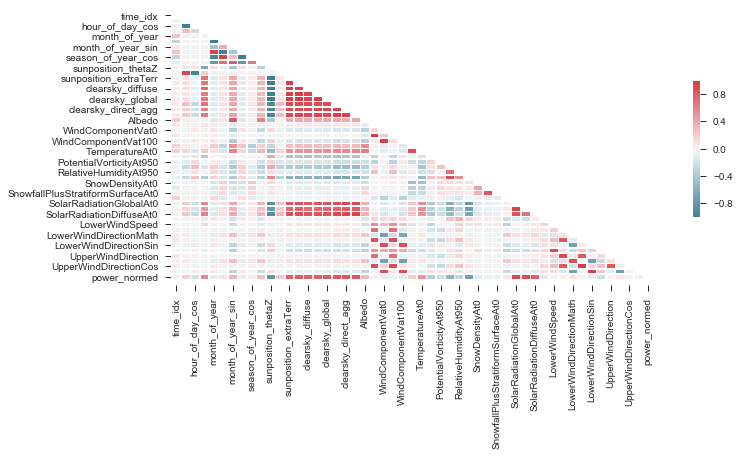

In [13]:
plot_correlation_matrix(df)

In [ ]:
def check_index(df):
    check = pd.DatetimeIndex(start=df.index[0], end=df.index[-1], freq='3h')

## Train-Validate-Test Split
Split data into train, validate, test dataset


In [14]:
def split_data(data, val_size=0.2, test_size=0.2):
    ntest = int(round(len(data) * (1 - test_size)))
    nval = int(round(len(data.iloc[:ntest]) * (1 - val_size)))
    
    df_train, df_val, df_test = data.iloc[:nval], data.iloc[nval:ntest], data.iloc[ntest:]
    
    return df_train, df_val, df_test

In [15]:
train, val, test = split_data(df, val_size=0.2, test_size=0.2)

In [16]:
train

,time_idx,hour_of_day,hour_of_day_cos,hour_of_day_sin,month_of_year,month_of_year_cos,month_of_year_sin,season_of_year,season_of_year_cos,season_of_year_sin,...,LowerWindDirectionMath,LowerWindDirectionCos,LowerWindDirectionSin,UpperWindSpeed,UpperWindDirection,UpperWindDirectionMath,UpperWindDirectionCos,UpperWindDirectionSin,power_normed,Unnamed: 51
0,1.0,0.000000,1.000000,0.000000,0.909091,0.017332,0.258819,1.0,0.0,0.000000,...,0.190752,0.681740,0.965801,0.359087,0.577455,0.172559,0.733785,0.941978,0.000000,NaN
1,2.0,0.142857,0.957824,0.399332,0.909091,0.017332,0.258819,1.0,0.0,0.000000,...,0.217852,0.600192,0.989859,0.475393,0.545543,0.204424,0.641217,0.979643,0.000000,NaN
2,3.0,0.285714,0.838278,0.732544,0.909091,0.017332,0.258819,1.0,0.0,0.000000,...,0.126020,0.851167,0.855924,0.472248,0.635529,0.114573,0.875928,0.829663,0.000000,NaN
3,4.0,0.428571,0.661157,0.944463,0.909091,0.017332,0.258819,1.0,0.0,0.000000,...,0.080266,0.937664,0.741765,0.591015,0.673493,0.076666,0.943093,0.731664,0.035185,NaN
4,5.0,0.571429,0.455788,1.000000,0.909091,0.017332,0.258819,1.0,0.0,0.000000,...,0.050633,0.974850,0.656581,0.641152,0.701128,0.049073,0.976413,0.651756,0.120988,NaN
5,6.0,0.714286,0.256176,0.889960,0.909091,0.017332,0.258819,1.0,0.0,0.000000,...,0.072509,0.948921,0.720160,0.634306,0.681408,0.068763,0.954045,0.709385,0.201235,NaN
6,7.0,0.857143,0.095371,0.632563,0.909091,0.017332,0.258819,1.0,0.0,0.000000,...,0.075553,0.944629,0.728703,0.658522,0.677493,0.072672,0.948766,0.720473,0.004321,NaN
7,8.0,1.000000,0.000000,0.270427,0.909091,0.017332,0.258819,1.0,0.0,0.000000,...,0.083723,0.932310,0.751213,0.594543,0.671081,0.079075,0.939536,0.738343,0.000000,NaN
8,9.0,0.000000,1.000000,0.000000,0.909091,0.017332,0.258819,1.0,0.0,0.000000,...,0.098199,0.907709,0.789437,0.548595,0.658273,0.091864,0.918987,0.772855,0.000000,NaN
9,10.0,0.142857,0.957824,0.399332,0.909091,0.017332,0.258819,1.0,0.0,0.000000,...,0.182227,0.706414,0.955404,0.458441,0.578866,0.171151,0.737686,0.939892,0.000000,NaN


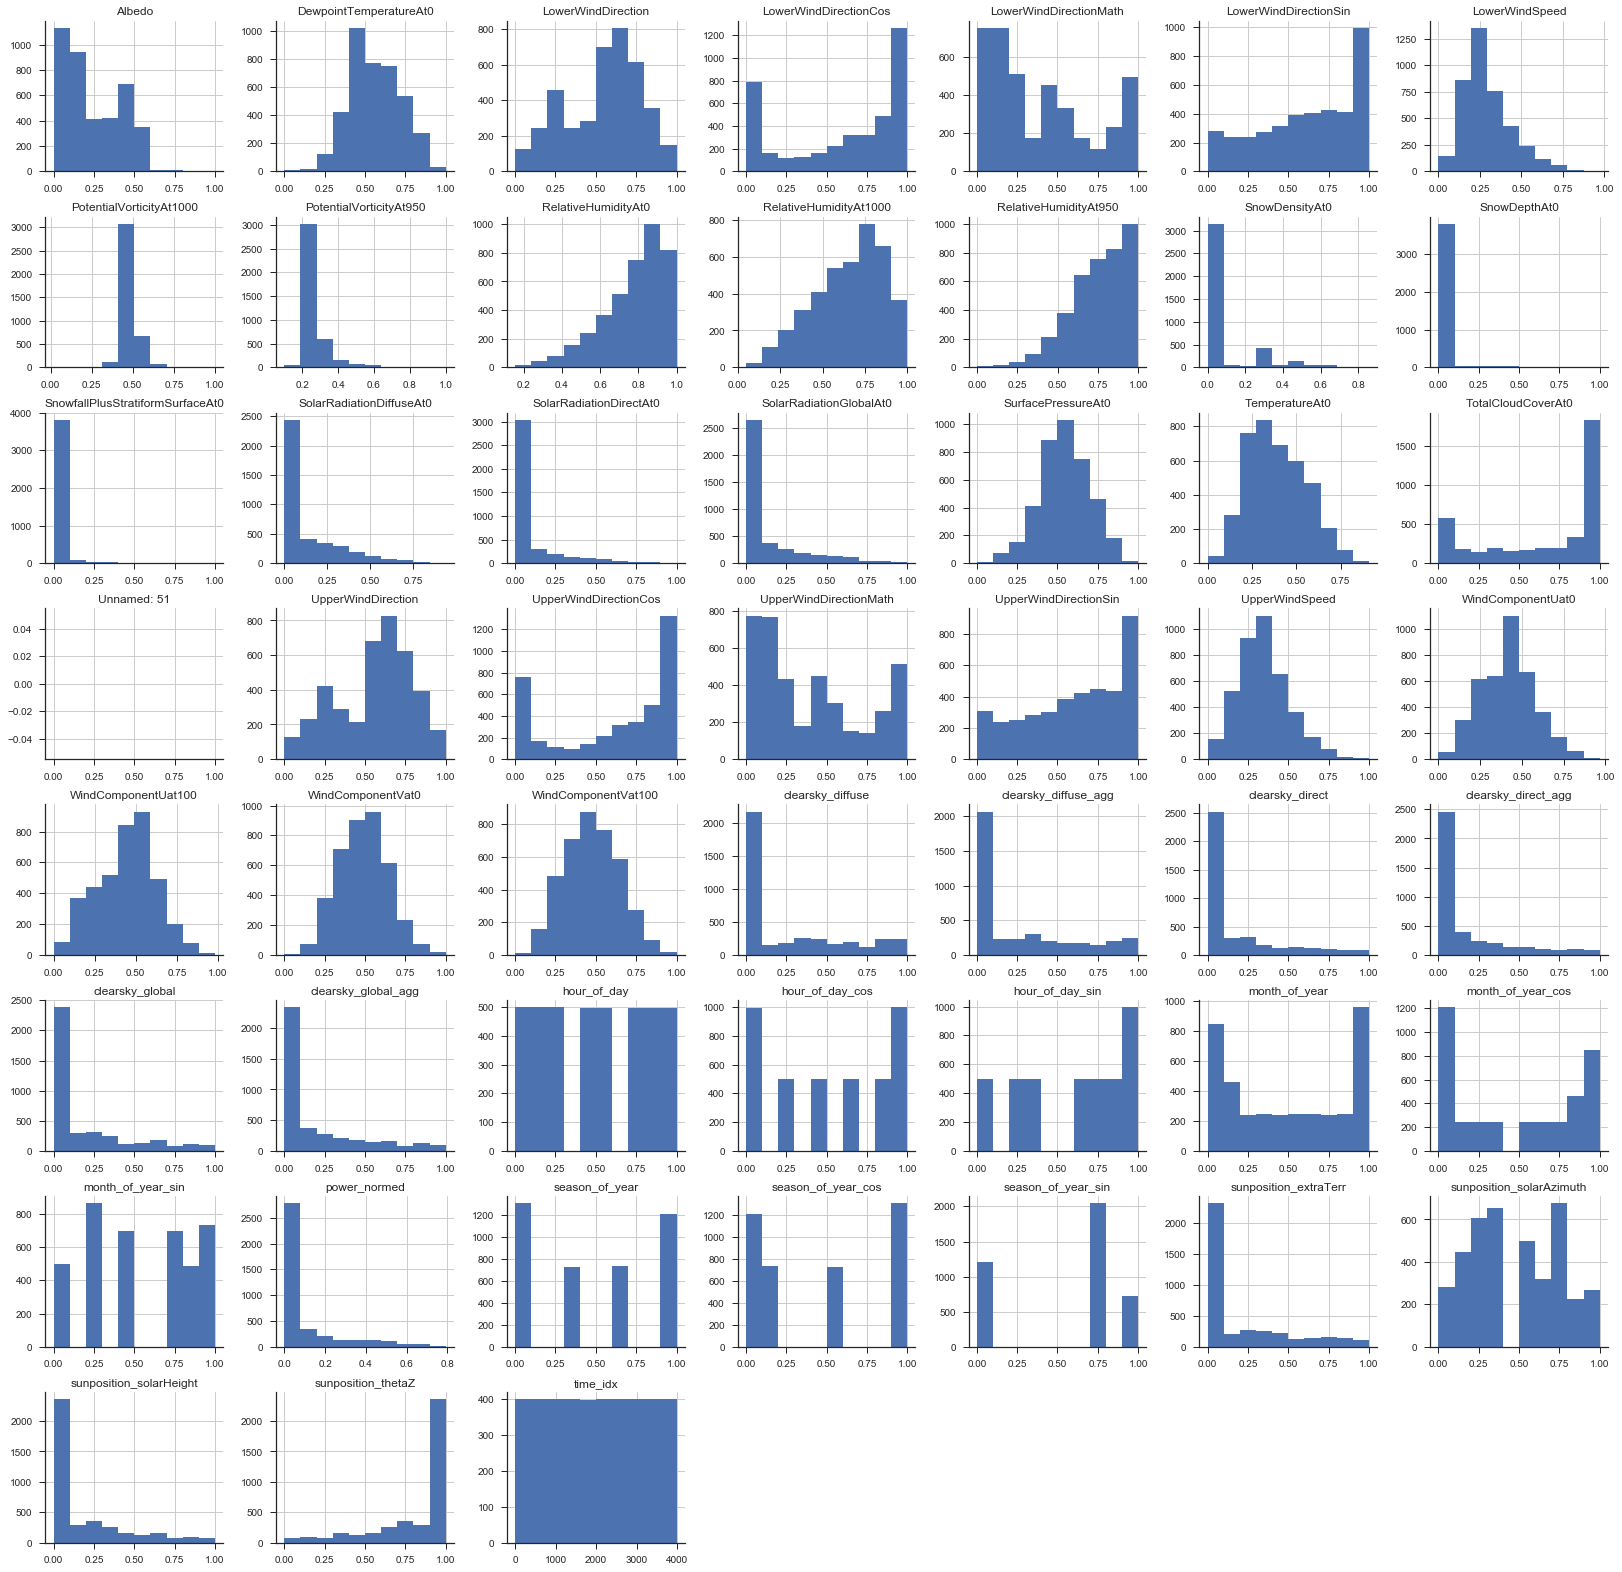

In [17]:
# histogram of the feature values 

train.hist(figsize=(28,28))
sns.despine()

In [19]:
feature_cols = [f for f in train.columns]

In [21]:
feature_cols = [f for f in train.columns if "power_normed" not in f]
target_col = train.columns[-1]

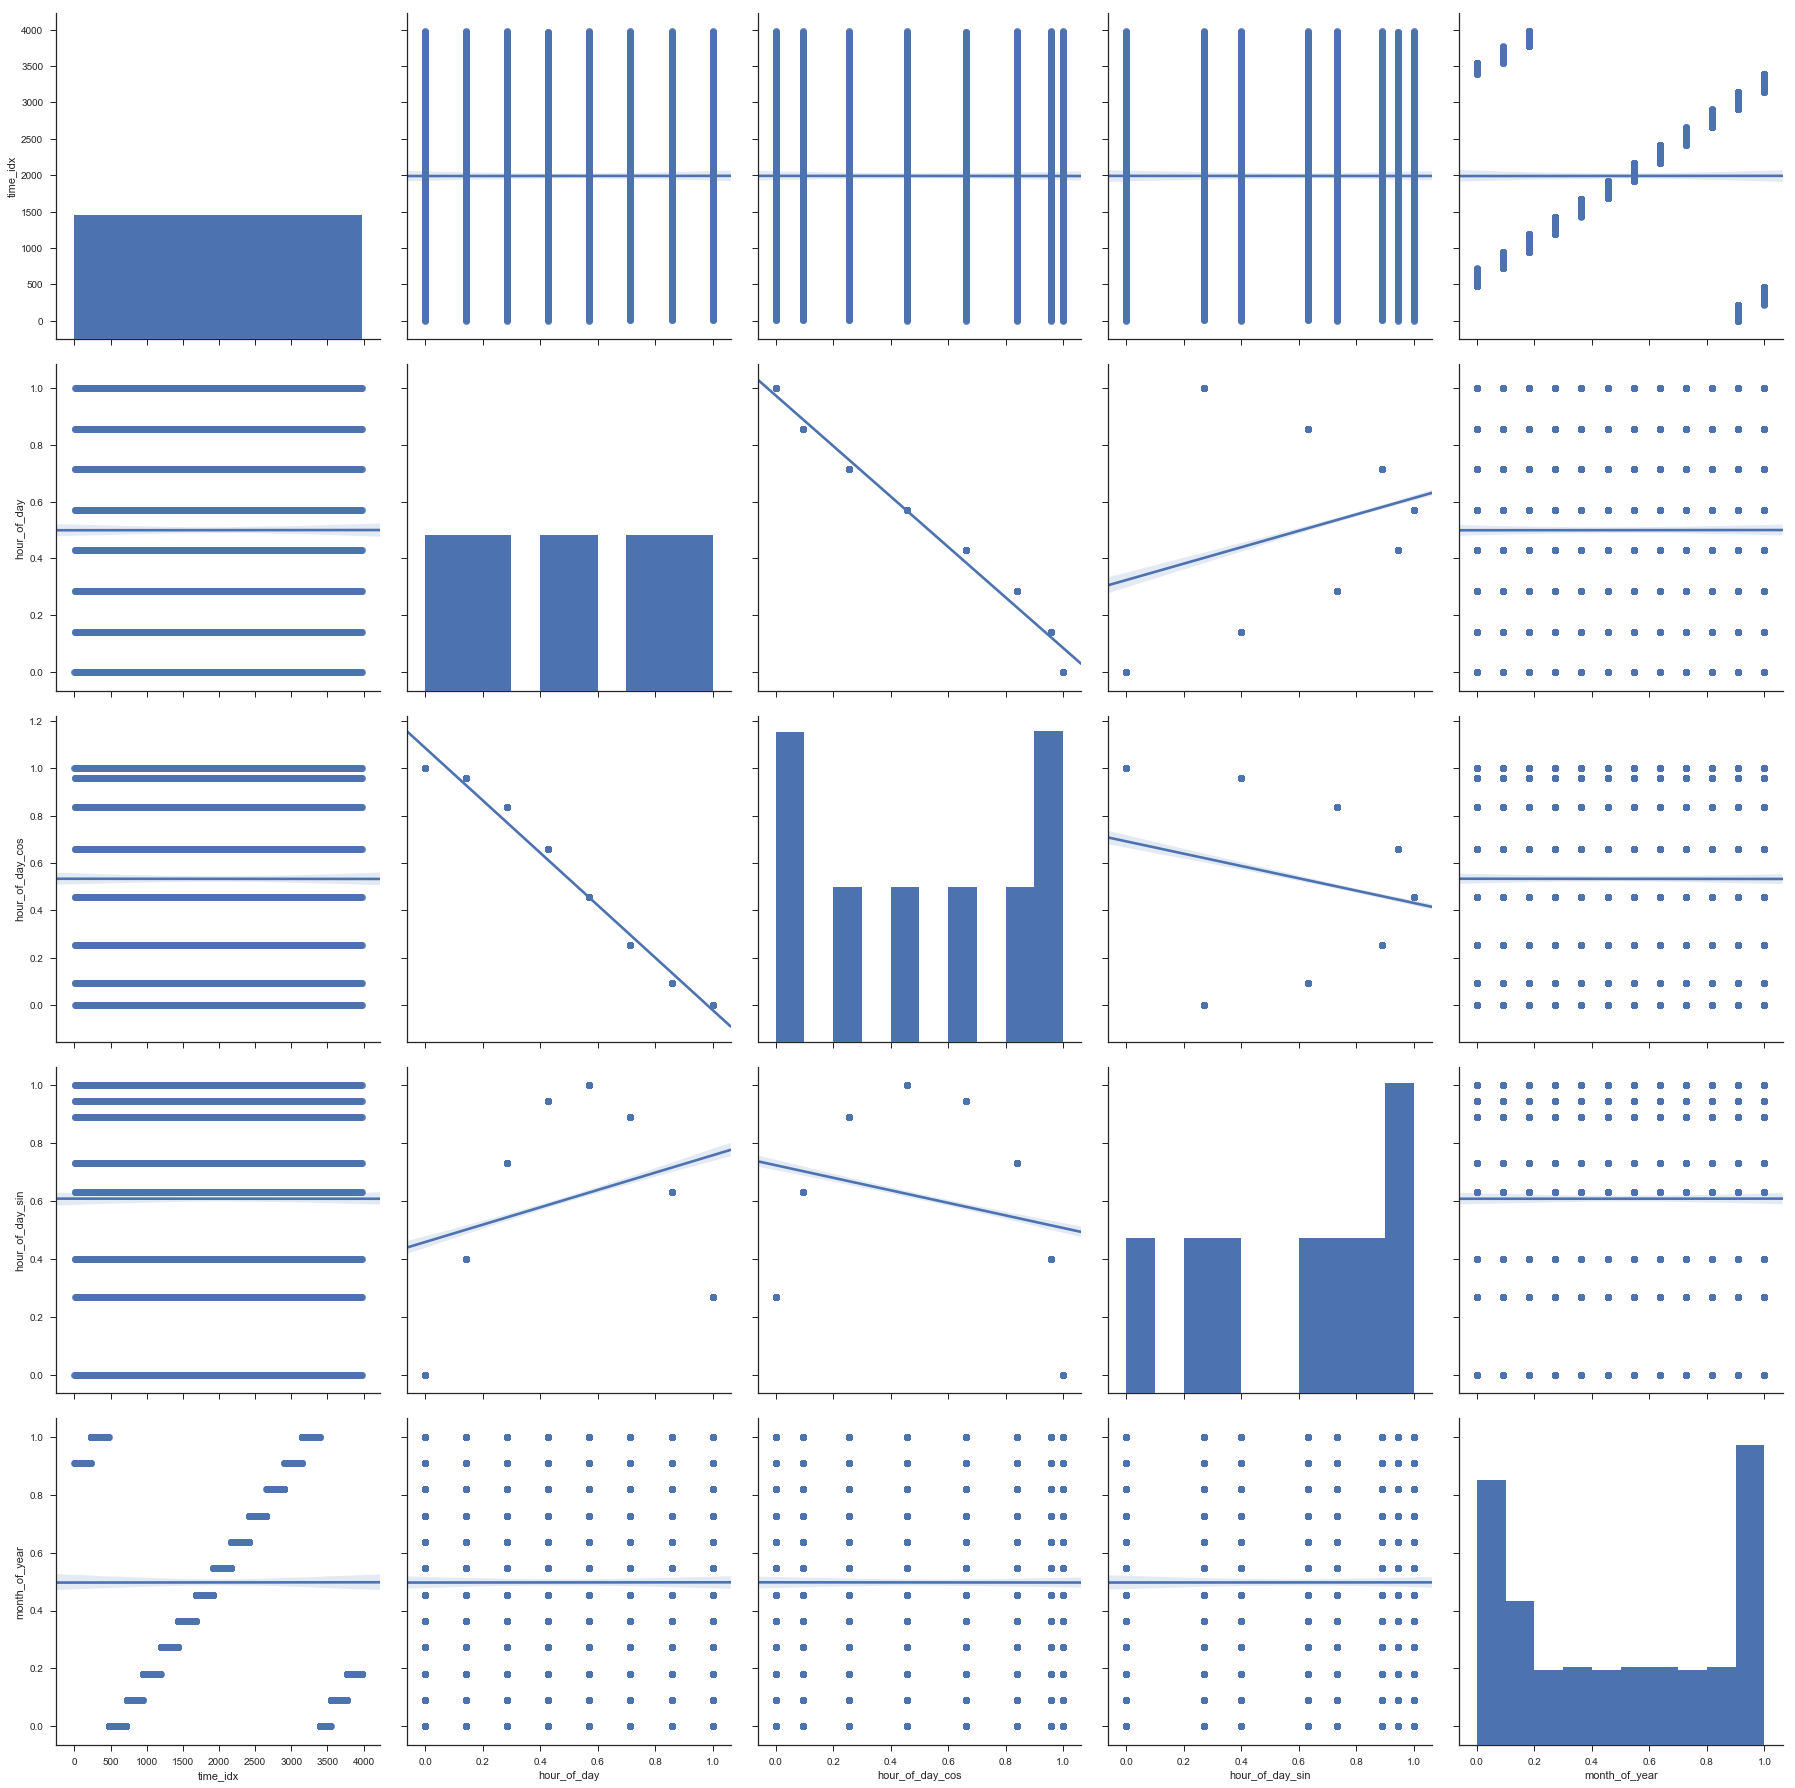

In [22]:
# feature pairplot

sns.pairplot(train, vars=feature_cols[0:5], kind="reg",size=5)
sns.despine()

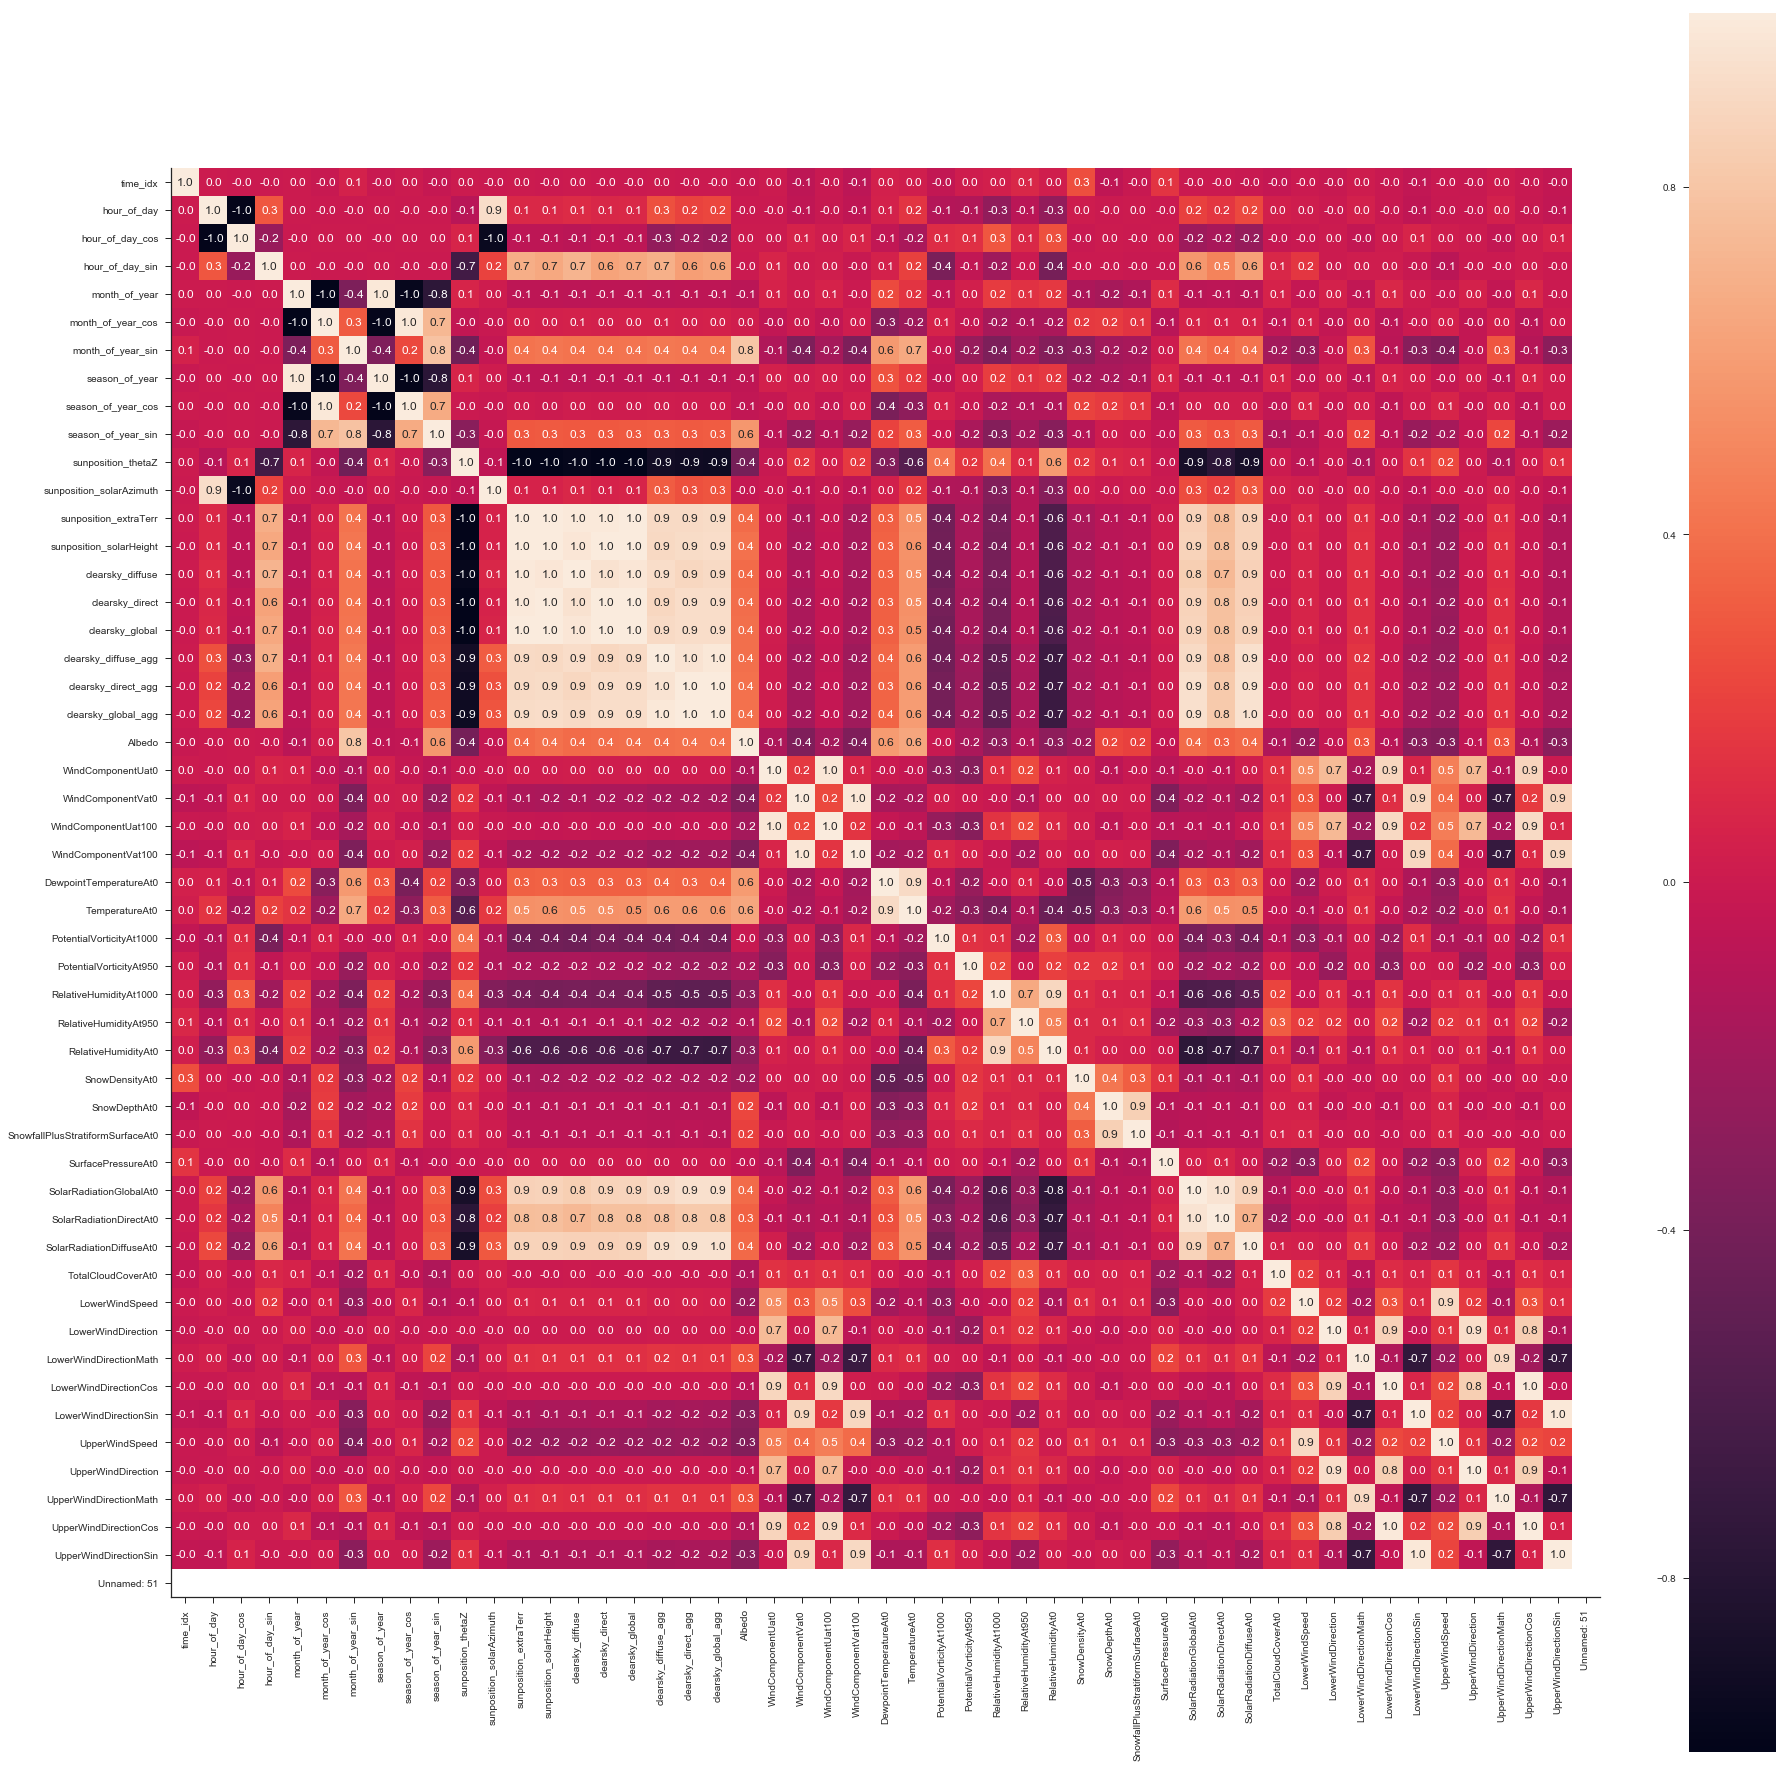

In [24]:
plt.figure(figsize=(32,32))
sns.heatmap(train[feature_cols].corr(), square=True,annot=True, fmt='.1f')
sns.despine()